In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from scipy.sparse.linalg import eigs
import cv2
from cv2 import Mat
import math
import random
from IPython.display import Image, display
from PIL import Image as im

In [100]:
class TransferedPicture: #画像の相似変換
    def __init__(self,pic:Mat,scale,theta,gray=False):
        self.orig_img=pic
        if gray==False:
            h,w,c=self.orig_img.shape
        else:
            h,w=self.orig_img.shape
        mat = cv2.getRotationMatrix2D((w / 2, h / 2), theta, scale) #相似変換のパラメータ設定
        self.img = cv2.warpAffine(pic, mat, (w, h)) #相似変換を実行
        self.scale=scale
        self.theta=theta
    
    def write(self,img_name):
        cv2.imwrite(img_name,self.img)
        
    def get_img_array(self): #オリジナル画像と変換後画像の配列を得る
        return self.orig_img, self.img
    
    def get_gray_array(self): #オリジナル画像と変換後画像のグレースケールでの配列を得る
        orig_gray=cv2.cvtColor(self.orig_img,cv2.COLOR_BGR2GRAY)
        img_gray=cv2.cvtColor(self.img,cv2.COLOR_BGR2GRAY)
        return orig_gray,img_gray
    
    def smooth_def(self): #x方向,y方向それぞれの平滑微分画像を生成
        #x方向の平滑微分画像
        gs_x=cv2.GaussianBlur(self.img,(3,3),3)
        kernel_x = 0.5 * np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]])
        dst_x = cv2.filter2D(gs_x, -1, kernel_x)
        dst_x=cv2.cvtColor(dst_x,cv2.COLOR_BGR2GRAY)
        
        #y方向の微分
        gs_y=cv2.GaussianBlur(self.img,(3,3),3)
        kernel_y = 0.5 * np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]])
        dst_y = cv2.filter2D(gs_y, -1, kernel_y)
        dst_y=cv2.cvtColor(dst_y,cv2.COLOR_BGR2GRAY)
        
        return dst_x,dst_y

In [109]:
class GaussNewton:
    def __init__(self,orig:np.array,st:np.array,i_x:np.array,i_y:np.array):
        #θとsを初期化
        self.theta=random.uniform(-180,180)
        self.scale=random.random()
        #各画像配列を保持
        self.orig=orig
        self.st=st
        self.i_x=i_x
        self.i_y=i_y
        self.h,self.w=orig.shape
        
    def dx_dtheta(self,x,y):
        return self.scale*(-2*x*np.sin(self.theta)-(2*y*np.cos(self.theta)))
    def dy_dtheta(self,x,y):
        return self.scale*(2*x*np.cos(self.theta)-(2*y*np.sin(self.theta)))
    def dx_dscale(self,x,y):
        return 2*x*np.cos(self.theta)-(2*y*np.sin(self.theta))
    def dy_dscale(self,x,y):
        return 2*x*np.sin(self.theta)-(2*y*np.cos(self.theta))
    
    #1周分の計算を行う
    def calc_param(self):
        h,w=int(self.h/2),int(self.w/2)
        j_t=j_tt=j_s=j_ss=j_ts=.0
        print("θ={0}, s={1}".format(self.theta,self.scale))
        for i in range(-1*h,h):
            for j in range(-1*w,w):
                #配列の座標を画像の中心を原点とした座標に変換
                x,y=j,-1*i #y軸の正の方向を向かせる
                x_d=int(self.scale*(np.cos(self.theta)*x-(np.sin(self.theta)*y)))
                y_d=int(self.scale*(np.sin(self.theta)*x+(np.cos(self.theta)*y)))
                
                dxdt=self.dx_dtheta(x_d,y_d)
                dydt=self.dy_dtheta(x_d,y_d)
                dxds=self.dx_dscale(x_d,y_d)
                dyds=self.dy_dscale(x_d,y_d)
                
                #配列の座標値に逆変換
                x,y=x+w,-1*y+h
                x_d,y_d=x_d+w-1,-1*y_d+h-1
                
                #各微分式の計算
                j_t+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))
                j_tt+=np.square(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))
                j_s+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))
                j_ss+=np.square((i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds)))
                j_ts+=(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))
        
        #delta_thetaとdelta_scaleの計算
        mt=np.array([[j_tt,j_ts],[j_ts,j_ss]])
        deltas=-1*np.linalg.inv(mt).dot(np.array([j_t,j_s]))
        print("Δθ={0}, Δs={1}".format(deltas[0],deltas[1]))
        return deltas[0],deltas[1]
    
    def until_convergence(self):
        eps=1e-8
        old_dt=old_ds=1000
        i=1
        while(True):
            print("{0}周目".format(i))
            new_dt,new_ds=self.calc_param()
            self.theta+=new_dt
            self.scale+=new_ds
            if abs(new_dt-old_dt)<eps and abs(new_ds-old_ds)<eps:
                print("収束を確認")
                print("最終値: θ={0}, s={1}".format(self.theta,self.scale))
                break
            i+=1
        pass

In [110]:
def imshow(img):
    #ndarray 配列から画像をNotebook上に表示
    ret, encoded = cv2.imencode(".jpg", img)
    display(Image(encoded))

In [111]:
pic_name="pic1.png"
pic_st_name="pic2.png"
#thetaとscaleの初期値を適当に決める
s,t=0.6,20
orig_img=cv2.imread(pic_name)
tp=TransferedPicture(pic=orig_img,scale=s,theta=t)
#画像データを得る
orig_img,st_img=tp.get_img_array()
orig_gray_img,st_gray_img=tp.get_gray_array()
#numpy配列化する
orig_array,st_array=np.array(orig_img),np.array(st_img)
orig_gray_array,st_gray_array=np.array(orig_gray_img),np.array(st_gray_img)

#Iの計算
h,w=st_gray_img.shape
i_x,i_y=tp.smooth_def()
i_x_array,i_y_array=np.array(i_x),np.array(i_y)

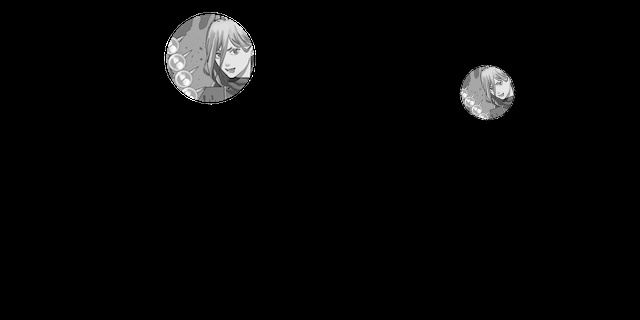

In [112]:
imgs=cv2.hconcat([orig_gray_img,st_gray_img])
imshow(imgs)

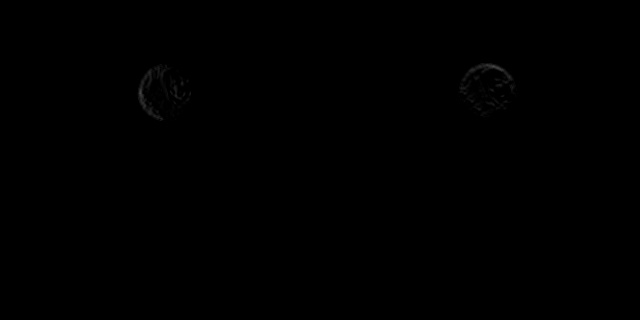

In [113]:
imgs=cv2.hconcat([i_x,i_y])
imshow(imgs)

In [114]:
gn=GaussNewton(orig=orig_gray_array,st=st_gray_array,i_x=i_x_array,i_y=i_y_array)
gn.until_convergence()

1周目
θ=-72.09141277519228, s=0.5207524997733802


/var/folders/5q/gwhjzy5s4nl5rhb5x_hsv9z40000gn/T/ipykernel_29906/3715362507.py:44: RuntimeWarning: overflow encountered in ubyte_scalars
  j_t+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))
/var/folders/5q/gwhjzy5s4nl5rhb5x_hsv9z40000gn/T/ipykernel_29906/3715362507.py:46: RuntimeWarning: overflow encountered in ubyte_scalars
  j_s+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))


Δθ=-0.07702504812561149, Δs=-0.028522552620003267
2周目
θ=-72.16843782331789, s=0.492229947153377
Δθ=-0.10174822778269474, Δs=-0.026580780342496158
3周目
θ=-72.27018605110058, s=0.4656491668108808
Δθ=-0.12565723590782765, Δs=-0.02201442124046455
4周目
θ=-72.3958432870084, s=0.44363474557041627
Δθ=-0.16533467902437393, Δs=-0.020617073863675176
5周目
θ=-72.56117796603277, s=0.4230176717067411
Δθ=-0.18135131792101272, Δs=-0.022291806275526977
6周目
θ=-72.74252928395379, s=0.40072586543121413
Δθ=-0.20391973516562273, Δs=-0.016970760196184577
7周目
θ=-72.94644901911941, s=0.38375510523502954
Δθ=-0.22791490250763777, Δs=0.010786239233506321
8周目
θ=-73.17436392162705, s=0.39454134446853584
Δθ=-0.11423559746439332, Δs=0.034379160090721936
9周目
θ=-73.28859951909143, s=0.4289205045592578
Δθ=-0.09632693835163782, Δs=0.031526774310744334
10周目
θ=-73.38492645744307, s=0.46044727887000214
Δθ=-0.08712578912456448, Δs=0.025744012422054523
11周目
θ=-73.47205224656764, s=0.4861912912920567
Δθ=-0.08049676135670186, Δs=0.

IndexError: index 320 is out of bounds for axis 0 with size 320

In [74]:
def dx_dtheta(x,y,scale,theta):
    return scale*(-2*x*np.sin(theta)-(2*y*np.cos(theta)))
def dy_dtheta(x,y,scale,theta):
    return scale*(2*x*np.cos(theta)-(2*y*np.sin(theta)))
def dx_dscale(x,y,scale,theta):
    return 2*x*np.cos(theta)-(2*y*np.sin(theta))
def dy_dscale(x,y,scale,theta):
    return 2*x*np.sin(theta)-(2*y*np.cos(theta))

#J_thetaを計算
def J_theta(h,w,scale,theta):
    h,w=int(h/2),int(w/2)
    sum=.0
    for i in range(-1*h,h):
        for j in range(-1*w,w):
            #回転の中心は画像の中心になるのでその分の補正を行う
            x,y=j,-1*i #y軸の正の方向を向かせる
            x_d=int(scale*(np.cos(theta)*x-(np.sin(theta)*y)))
            y_d=int(scale*(np.sin(theta)*x+(np.cos(theta)*y)))
            dxdt=dx_dtheta(x_d,y_d,scale,theta)
            dydt=dy_dtheta(x_d,y_d,scale,theta)
            
            x,y=x+w,-1*y+h
            x_d,y_d=x_d+w,-1*y_d+h
            #print(y_d,x_d)
            sum+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))
                        
    return sum
j_t=J_theta(h,w,scale,theta)

/var/folders/5q/gwhjzy5s4nl5rhb5x_hsv9z40000gn/T/ipykernel_29906/717106919.py:26: RuntimeWarning: overflow encountered in ubyte_scalars
  sum+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))


In [75]:
#J_thetathetaを計算
def J_thetatheta(h,w,scale,theta):
    h,w=int(h/2),int(w/2)
    sum=.0
    for i in range(-1*h,h):
        for j in range(-1*w,w):
            #回転の中心は画像の中心になるのでその分の補正を行う
            x,y=j,-1*i #y軸の正の方向を向かせる
            x_d=int(scale*(np.cos(theta)*x-(np.sin(theta)*y)))
            y_d=int(scale*(np.sin(theta)*x+(np.cos(theta)*y)))
            dxdt=dx_dtheta(x_d,y_d,scale,theta)
            dydt=dy_dtheta(x_d,y_d,scale,theta)
            
            x,y=x+w,-1*y+h
            x_d,y_d=x_d+w,-1*y_d+h
            sum+=(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))*(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))      

    return sum
j_tt=J_thetatheta(h,w,scale,theta)

In [76]:
def J_scale(h,w,scale,theta):
    h,w=int(h/2),int(w/2)
    sum=.0
    for i in range(-1*h,h):
        for j in range(-1*w,w):
            #回転の中心は画像の中心になるのでその分の補正を行う
            x,y=j,-1*i #y軸の正の方向を向かせる
            x_d=int(scale*(np.cos(theta)*x-(np.sin(theta)*y)))
            y_d=int(scale*(np.sin(theta)*x+(np.cos(theta)*y)))
            dxds=dx_dscale(x_d,y_d,scale,theta)
            dyds=dy_dscale(x_d,y_d,scale,theta)
            
            x,y=x+w,-1*y+h
            x_d,y_d=x_d+w,-1*y_d+h
            #print(y_d,x_d)
            sum+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))
                        
    return sum
j_s=J_scale(h,w,scale,theta)

/var/folders/5q/gwhjzy5s4nl5rhb5x_hsv9z40000gn/T/ipykernel_29906/3770831282.py:16: RuntimeWarning: overflow encountered in ubyte_scalars
  sum+=(st_gray_array[x_d][y_d]-orig_gray_array[x][y])*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))


In [77]:
#J_thetathetaを計算
def J_scalescale(h,w,scale,theta):
    h,w=int(h/2),int(w/2)
    sum=.0
    for i in range(-1*h,h):
        for j in range(-1*w,w):
            #回転の中心は画像の中心になるのでその分の補正を行う
            x,y=j,-1*i #y軸の正の方向を向かせる
            x_d=int(scale*(np.cos(theta)*x-(np.sin(theta)*y)))
            y_d=int(scale*(np.sin(theta)*x+(np.cos(theta)*y)))
            dxds=dx_dscale(x_d,y_d,scale,theta)
            dyds=dy_dscale(x_d,y_d,scale,theta)
            
            x,y=x+w,-1*y+h
            x_d,y_d=x_d+w,-1*y_d+h
            sum+=(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))      

    return sum
j_ss=J_scalescale(h,w,scale,theta)

In [78]:
#J_thetathetaを計算
def J_thetascale(h,w,scale,theta):
    h,w=int(h/2),int(w/2)
    sum=.0
    for i in range(-1*h,h):
        for j in range(-1*w,w):
            #回転の中心は画像の中心になるのでその分の補正を行う
            x,y=j,-1*i #y軸の正の方向を向かせる
            x_d=int(scale*(np.cos(theta)*x-(np.sin(theta)*y)))
            y_d=int(scale*(np.sin(theta)*x+(np.cos(theta)*y)))
            dxdt=dx_dtheta(x_d,y_d,scale,theta)
            dydt=dy_dtheta(x_d,y_d,scale,theta)
            dxds=dx_dscale(x_d,y_d,scale,theta)
            dyds=dy_dscale(x_d,y_d,scale,theta)
            
            x,y=x+w,-1*y+h
            x_d,y_d=x_d+w,-1*y_d+h
            sum+=(i_x_array[x_d][y_d]*dxdt+(i_y_array[x_d][y_d]*dydt))*(i_x_array[x_d][y_d]*dxds+(i_y_array[x_d][y_d]*dyds))      

    return sum
j_ts=J_thetascale(h,w,scale,theta)

In [79]:
mt=np.array([[j_tt,j_ts],[j_ts,j_ss]])
-1*np.linalg.inv(mt).dot(np.array([j_t,j_s]))

array([-0.00119878,  0.00208636])